## 1. Imports

In [1]:
### Base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Models
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

### Preprocessing
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

### Model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split

### Metrics and model evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_roc_curve, plot_precision_recall_curve
from lightgbm import plot_importance

### Oversampling, undersampling and SMOTE
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

In [2]:
train_data_raw = pd.read_csv('Data/aug_train.csv')
train_data_raw.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
train_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [4]:
print('Porcentaje de nulos')
print((train_data_raw.isnull().sum()/train_data_raw.shape[0]*100).round(2))

Porcentaje de nulos
enrollee_id                0.00
city                       0.00
city_development_index     0.00
gender                    23.53
relevent_experience        0.00
enrolled_university        2.01
education_level            2.40
major_discipline          14.68
experience                 0.34
company_size              30.99
company_type              32.05
last_new_job               2.21
training_hours             0.00
target                     0.00
dtype: float64


_____

## 2. Pipeline

### 2.1 Preprocessing Steps

In [5]:
### Numerical features

numerical_cols = ['city_development_index', 'training_hours']

numerical_transformer_1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())])

numerical_transformer_2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
    ('scaler', StandardScaler())])

In [6]:
### Categorical features

categorical_cols = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 
                    'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

categorical_transformer_1 = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

categorical_transformer_2 = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Empty')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

In [7]:
### Preprocessing Pipelines

preprocessing_step_1 = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer_1, numerical_cols),
        ('cat', categorical_transformer_1, categorical_cols)])

preprocessing_step_2 = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer_2, numerical_cols),
        ('cat', categorical_transformer_2, categorical_cols)])

### 2.2 Sampling Steps

In [8]:
### Oversampling

oversampling_step = RandomOverSampler()

In [9]:
### Undersampling

undersampling_step = RandomUnderSampler()

In [10]:
### SMOTE

smote_step = SMOTE()

### 2.3 Model Steps

In [11]:
### RandomForest Regressor

lgbm_step = LGBMClassifier(verbose = 1)

### 2.4 Pipeline Union

In [12]:
full_pipeline = imbPipeline(steps = [
    ('preprocessor', preprocessing_step_1),
    ('sampler', oversampling_step),
    ('model', lgbm_step)
])

_____

## 3. Train-test Split

In [13]:
X = train_data_raw.drop(['target', 'enrollee_id'], axis = 1)
y = train_data_raw['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = .75, random_state = 1942, shuffle = True, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14368, 12)
(14368,)
(4790, 12)
(4790,)


_____

## 4. Modelling

### 4.1 GridSearch Parameters

In [14]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1942)

In [15]:
param_grid = [{'preprocessor':[preprocessing_step_1, preprocessing_step_2],
               'sampler': [None],
               'model__boosting_type' : ['gbdt', 'dart', 'goss'],
               'model__reg_lambda' : [0, 10, 100, 1000],
               'model__is_unbalance':[False, True]},
              
              {'preprocessor':[preprocessing_step_1, preprocessing_step_2],
               'sampler': [oversampling_step],
               'sampler__sampling_strategy' : [1, .9, .8, .7, .6, .5],
               'model__boosting_type' : ['gbdt', 'dart', 'goss'],
               'model__reg_lambda' : [0, 10, 100, 1000],
               'model__is_unbalance':[False, True]},
              
              {'preprocessor':[preprocessing_step_1, preprocessing_step_2],
               'sampler': [undersampling_step],
               'sampler__sampling_strategy' : [1, .9, .8, .7, .6, .5],
               'model__boosting_type' : ['gbdt', 'dart', 'goss'],
               'model__reg_lambda' : [0, 10, 100, 1000],
               'model__is_unbalance':[False, True]},
              
              {'preprocessor':[preprocessing_step_1, preprocessing_step_2],
               'sampler': [smote_step],
               'sampler__sampling_strategy' : [1, .9, .8, .7, .6, .5],
               'model__boosting_type' : ['gbdt', 'dart', 'goss'],
               'model__reg_lambda' : [0, 10, 100, 1000],
               'model__is_unbalance':[False, True]}]

In [16]:
scoring = {'ROC' : 'roc_auc', 'Recall' : 'recall'}

In [17]:
grid_search = GridSearchCV(full_pipeline, param_grid, cv = folds, scoring = scoring, refit = 'ROC')

### 4.2 Model Selection

In [18]:
grid_search.fit(pd.DataFrame(X_train, columns=X.columns), y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1942, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['city_development_index',
                                                                          'training_hours']),
                                                                        ('cat',
                                                                         Pi

In [19]:
results = pd.DataFrame(grid_search.cv_results_)
results
#pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns', None)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__boosting_type,param_model__is_unbalance,param_model__reg_lambda,param_preprocessor,param_sampler,param_sampler__sampling_strategy,...,std_test_ROC,rank_test_ROC,split0_test_Recall,split1_test_Recall,split2_test_Recall,split3_test_Recall,split4_test_Recall,mean_test_Recall,std_test_Recall,rank_test_Recall
0,1.412481,0.760715,0.136408,0.081039,gbdt,False,0,"ColumnTransformer(transformers=[('num',\n ...",None,NaN,...,0.005690,746,0.435146,0.447699,0.442120,0.446927,0.439944,0.442367,0.004632,899
1,0.350620,0.072419,0.085405,0.010092,gbdt,False,0,"ColumnTransformer(transformers=[('num',\n ...",None,NaN,...,0.007038,144,0.560669,0.556485,0.581590,0.568436,0.576816,0.568799,0.009442,825
2,0.764044,0.064833,0.093605,0.009892,gbdt,False,10,"ColumnTransformer(transformers=[('num',\n ...",None,NaN,...,0.007253,523,0.432357,0.456067,0.428173,0.421788,0.449721,0.437621,0.013072,902
3,0.308818,0.008281,0.085805,0.001166,gbdt,False,10,"ColumnTransformer(transformers=[('num',\n ...",None,NaN,...,0.007546,17,0.566248,0.556485,0.566248,0.560056,0.569832,0.563774,0.004814,833
4,0.864850,0.089665,0.132608,0.040463,gbdt,False,100,"ColumnTransformer(transformers=[('num',\n ...",None,NaN,...,0.007420,462,0.432357,0.453278,0.412831,0.423184,0.439944,0.432319,0.013861,903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,1.479885,0.218450,0.099206,0.010028,goss,True,1000,"ColumnTransformer(transformers=[('num',\n ...",SMOTE(),0.9,...,0.008792,331,0.693166,0.695955,0.754533,0.712291,0.708101,0.712809,0.022060,440
908,1.244071,0.081479,0.097806,0.014442,goss,True,1000,"ColumnTransformer(transformers=[('num',\n ...",SMOTE(),0.8,...,0.008311,325,0.700139,0.709902,0.748954,0.719274,0.710894,0.717833,0.016701,406
909,1.146465,0.053237,0.090805,0.007305,goss,True,1000,"ColumnTransformer(transformers=[('num',\n ...",SMOTE(),0.7,...,0.008298,240,0.701534,0.711297,0.761506,0.720670,0.719274,0.722856,0.020492,375
910,1.074461,0.067563,0.099606,0.021277,goss,True,1000,"ColumnTransformer(transformers=[('num',\n ...",SMOTE(),0.6,...,0.008487,236,0.705718,0.722455,0.761506,0.724860,0.726257,0.728159,0.018235,321


In [21]:
grid_search.best_params_

{'model__boosting_type': 'dart',
 'model__is_unbalance': False,
 'model__reg_lambda': 100,
 'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(fill_value=0,
                                                                 strategy='constant')),
                                                  ('scaler', StandardScaler())]),
                                  ['city_development_index', 'training_hours']),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(fill_value='Empty',
                                                                 strategy='constant')),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                            

### 4.3 Best Model

In [22]:
training_performance = grid_search.best_estimator_.predict(X_train)

In [23]:
validation_performance = grid_search.best_estimator_.predict(X_test)

In [24]:
best_estimator = grid_search.best_estimator_
best_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['city_development_index',
                                                   'training_hours']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Empty',
                                                                                 str

_____

## 5. Model Evaluation - Training and Validation Sets

              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86     10785
         1.0       0.57      0.73      0.64      3583

    accuracy                           0.80     14368
   macro avg       0.74      0.77      0.75     14368
weighted avg       0.82      0.80      0.80     14368



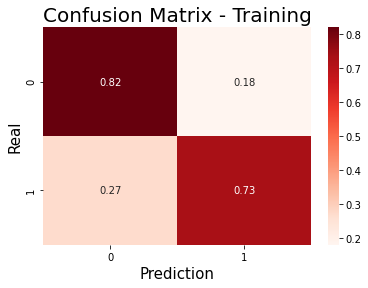

In [25]:
print(classification_report(y_train, training_performance))
cm = confusion_matrix(y_train, training_performance, normalize = 'true')
ax = sns.heatmap(cm, annot = True, cmap = 'Reds')
ax.set_xlabel('Prediction', fontsize = 15)
ax.set_ylabel('Real', fontsize = 15)
ax.set_title('Confusion Matrix - Training', fontsize = 20)
plt.show()

              precision    recall  f1-score   support

         0.0       0.90      0.81      0.86      3596
         1.0       0.57      0.74      0.64      1194

    accuracy                           0.80      4790
   macro avg       0.74      0.78      0.75      4790
weighted avg       0.82      0.80      0.80      4790



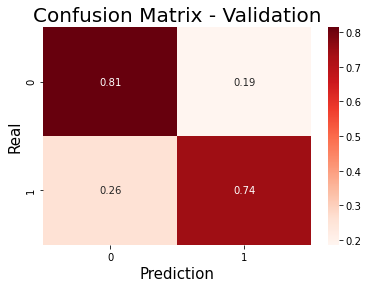

In [26]:
print(classification_report(y_test, validation_performance))
cm = confusion_matrix(y_test, validation_performance, normalize = 'true')
ax = sns.heatmap(cm, annot = True, cmap = 'Reds')
ax.set_xlabel('Prediction', fontsize = 15)
ax.set_ylabel('Real', fontsize = 15)
ax.set_title('Confusion Matrix - Validation', fontsize = 20)
plt.show()

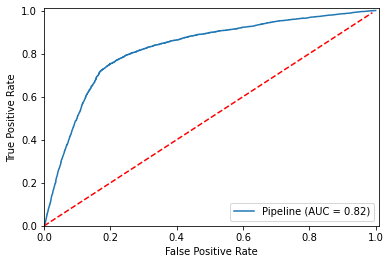

In [27]:
plot_roc_curve(grid_search.best_estimator_, X_train, y_train)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), linestyle = '--', color = 'red')
plt.axis([0, 1.01, 0, 1.01])
plt.show()

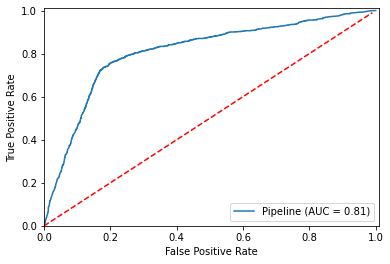

In [28]:
plot_roc_curve(grid_search.best_estimator_, X_test, y_test)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), linestyle = '--', color = 'red')
plt.axis([0, 1.01, 0, 1.01])
plt.show()

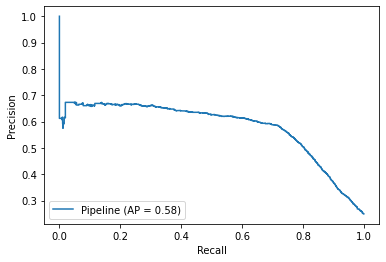

In [29]:
plot_precision_recall_curve(grid_search.best_estimator_, X_train, y_train)

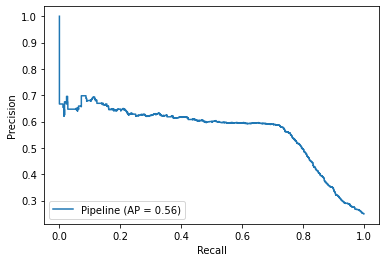

In [30]:
plot_precision_recall_curve(grid_search.best_estimator_, X_test, y_test)

In [31]:
feature_importance = grid_search.best_estimator_.named_steps['model'].feature_importances_

In [32]:
cat_features_list = grid_search.best_estimator_.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['encoder'].get_feature_names(categorical_cols)

num_features_list = ['city_development_index', 'training_hours']

for i in cat_features_list:
    num_features_list.append(i)

In [33]:
feature_importance = pd.DataFrame(feature_importance, index = num_features_list, columns = ['feature_importance'])
feature_importance = feature_importance.sort_values(by = 'feature_importance', ascending = False)

In [34]:
feature_importance.head(10)

,feature_importance
city_development_index,499
training_hours,474
company_size_Empty,110
major_discipline_Empty,83
city_city_103,77
city_city_144,74
experience_>20,73
relevent_experience_Has relevent experience,73
city_city_115,66
enrolled_university_Full time course,65


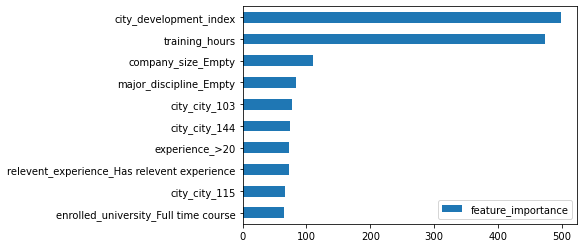

In [35]:
ax = feature_importance[0:10].plot.barh()
ax.invert_yaxis()

In [36]:
proba_list = grid_search.best_estimator_.predict_proba(X_test)

In [37]:
new_proba = .4

modified_results = pd.Series(proba_list[:,1] >= new_proba).astype('int64')
modified_results

0       0
1       0
2       1
3       0
4       0
       ..
4785    1
4786    0
4787    0
4788    0
4789    1
Length: 4790, dtype: int64

              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83      3596
         1.0       0.53      0.77      0.63      1194

    accuracy                           0.77      4790
   macro avg       0.72      0.77      0.73      4790
weighted avg       0.82      0.77      0.78      4790



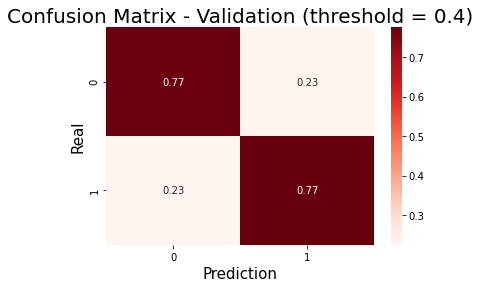

In [38]:
print(classification_report(y_test, modified_results))
cm = confusion_matrix(y_test, modified_results, normalize = 'true')
ax = sns.heatmap(cm, annot = True, cmap = 'Reds')
ax.set_xlabel('Prediction', fontsize = 15)
ax.set_ylabel('Real', fontsize = 15)
ax.set_title(f'Confusion Matrix - Validation (threshold = {new_proba})', fontsize = 20)
plt.show()

_____

## 6. Model Evaluation - Testing Set

In [39]:
test_data_raw = pd.read_csv('Data/aug_test.csv')
test_data_raw.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [40]:
test_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


In [41]:
print('Porcentaje de nulos')
print((test_data_raw.isnull().sum()/test_data_raw.shape[0]*100).round(2))

Porcentaje de nulos
enrollee_id                0.00
city                       0.00
city_development_index     0.00
gender                    23.86
relevent_experience        0.00
enrolled_university        1.46
education_level            2.44
major_discipline          14.65
experience                 0.23
company_size              29.22
company_type              29.78
last_new_job               1.88
training_hours             0.00
dtype: float64


In [42]:
X_test_final = test_data_raw.drop('enrollee_id', axis = 1)
y_test_final = np.load('jobchange_test_target_values.npy')

In [43]:
testing_performance = grid_search.best_estimator_.predict(X_test_final)

              precision    recall  f1-score   support

         0.0       0.89      0.82      0.85      1553
         1.0       0.60      0.71      0.65       576

    accuracy                           0.79      2129
   macro avg       0.74      0.77      0.75      2129
weighted avg       0.81      0.79      0.80      2129



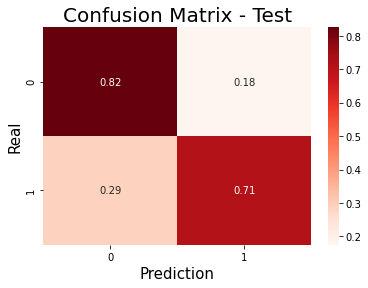

In [44]:
print(classification_report(y_test_final, testing_performance))
cm = confusion_matrix(y_test_final, testing_performance, normalize = 'true')
ax = sns.heatmap(cm, annot = True, cmap = 'Reds')
ax.set_xlabel('Prediction', fontsize = 15)
ax.set_ylabel('Real', fontsize = 15)
ax.set_title('Confusion Matrix - Test', fontsize = 20)
plt.show()

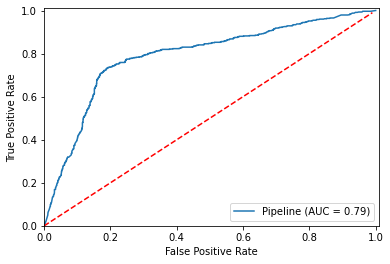

In [45]:
plot_roc_curve(grid_search.best_estimator_, X_test_final, y_test_final)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), linestyle = '--', color = 'red')
plt.axis([0, 1.01, 0, 1.01])
plt.show()

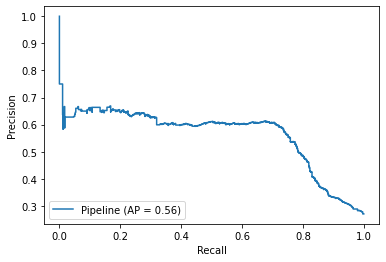

In [46]:
plot_precision_recall_curve(grid_search.best_estimator_, X_test_final, y_test_final)

In [47]:
proba_list_testing = grid_search.best_estimator_.predict_proba(X_test_final)

In [48]:
modified_testing_results = pd.Series(proba_list_testing[:,1] >=.4).astype('int64')
modified_testing_results

0       1
1       0
2       1
3       0
4       0
       ..
2124    1
2125    0
2126    0
2127    0
2128    0
Length: 2129, dtype: int64

              precision    recall  f1-score   support

         0.0       0.89      0.78      0.83      1553
         1.0       0.56      0.75      0.64       576

    accuracy                           0.77      2129
   macro avg       0.73      0.77      0.74      2129
weighted avg       0.80      0.77      0.78      2129



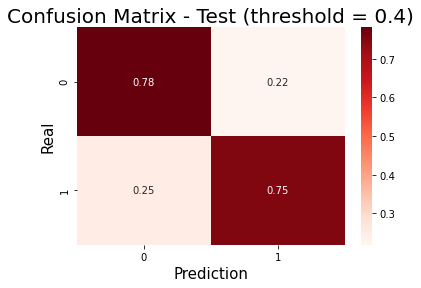

In [49]:
print(classification_report(y_test_final, modified_testing_results))
cm = confusion_matrix(y_test_final, modified_testing_results, normalize = 'true')
ax = sns.heatmap(cm, annot = True, cmap = 'Reds')
ax.set_xlabel('Prediction', fontsize = 15)
ax.set_ylabel('Real', fontsize = 15)
ax.set_title(f'Confusion Matrix - Test (threshold = {new_proba})', fontsize = 20)
plt.show()